In [66]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/GITHUB/pytorch_basic/pytorch
from multi_class_functions2_1 import *


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GITHUB/pytorch_basic/pytorch


In [67]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import copy
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [83]:
BATCH_SIZE = 32
LR = 1e-3
LR_STEP = 50
LR_GAMMA = 0.9
EPOCH = 5
TRAIN_RATIO = 0.8
new_model_Train = True
model_type = "CNN_deep"
save_model_path = f"/content/drive/MyDrive/Colab notebooks/data/results/{model_type}_STL10.pt"

In [69]:
def to_uint8(x):
    return (255*x).type(torch.uint8)

In [71]:
transform_train = transforms.ToTensor()
transform_test = transforms.ToTensor()
train_DS = datasets.STL10(root = '/content/drive/MyDrive/Colab Notebooks/data', split="train", download=True, transform=transform_train)
NoT = int(len(train_DS)* TRAIN_RATIO); NoV = len(train_DS) - NoT
train_DS, val_DS = torch.utils.data.random_split(train_DS, [NoT, NoV])
val_DS.transform = transform_test
test_DS = datasets.STL10(root = '/content/drive/MyDrive/Colab Notebooks/data', split="test", download=True, transform=transform_test)

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=False)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Colab Notebooks/data/stl10_binary.tar.gz to /content/drive/MyDrive/Colab Notebooks/data
Files already downloaded and verified


In [72]:
print(type(test_DS.data))
x,y = next(iter(train_DL))
print(type(x))
print(x.shape)

<class 'numpy.ndarray'>
<class 'torch.Tensor'>
torch.Size([32, 3, 96, 96])


In [73]:
print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

4000
1000
8000


In [74]:
class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block1 = nn.Sequential(nn.Conv2d(3,32,3, padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3, padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)
        
        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)

        self.fc = nn.Sequential(nn.Linear(128*12*12,512),
                                nn.Linear(512,10))

    def forward(self,x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x,start_dim=1)
        x = self.fc(x)
        return x

In [75]:
exec(f"model = {model_type}().to(DEVICE)")
# print(model)
print(model(torch.randn(32,3,96,96).to(DEVICE)).shape)

torch.Size([32, 10])


Epoch: 0, current_LR = 0.001


100%|██████████| 32/32 [00:00<00:00, 41.97it/s]


train loss: 1.61val loss: 1.59train acc: 38.8 %,val acc: 42.8 %, time: 8 s
--------------------
Epoch: 1, current_LR = 0.001


100%|██████████| 32/32 [00:00<00:00, 41.93it/s]


train loss: 1.46val loss: 1.45train acc: 44.5 %,val acc: 47.2 %, time: 8 s
--------------------
Epoch: 2, current_LR = 0.001


100%|██████████| 32/32 [00:00<00:00, 35.35it/s]


train loss: 1.34val loss: 1.37train acc: 50.9 %,val acc: 48.3 %, time: 9 s
--------------------
Epoch: 3, current_LR = 0.001


100%|██████████| 32/32 [00:00<00:00, 40.73it/s]


train loss: 1.22val loss: 1.26train acc: 55.1 %,val acc: 54.5 %, time: 9 s
--------------------
Epoch: 4, current_LR = 0.001


100%|██████████| 32/32 [00:00<00:00, 40.33it/s]


train loss: 1.14val loss: 1.38train acc: 59.0 %,val acc: 50.0 %, time: 8 s
--------------------


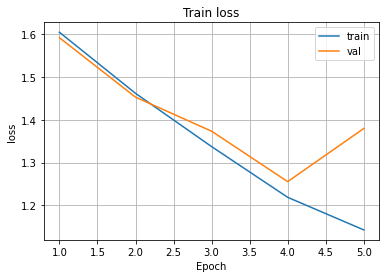

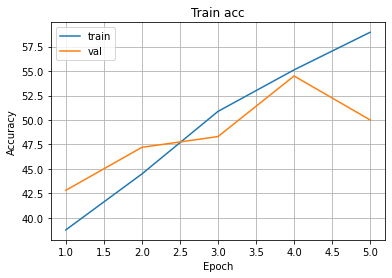

In [84]:
if new_model_Train:
    loss_history, acc_history = Train(model, train_DL, val_DL, LR=LR, LR_STEP = LR_STEP, LR_GAMMA = LR_GAMMA,
                                      EPOCH=EPOCH, BATCH_SIZE = BATCH_SIZE, TRAIN_RATIO = TRAIN_RATIO,
                                      save_model_path = save_model_path)

    plt.figure()
    plt.title("Train, Val Loss")
    plt.plot(range(1,EPOCH+1),loss_history["train"], label="train")
    plt.plot(range(1,EPOCH+1),loss_history["val"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("loss")
    plt.title("Train loss")
    plt.grid()
    plt.legend()

    plt.figure()
    plt.title("Train, Val Accuracy")
    plt.plot(range(1,EPOCH+1), acc_history["train"], label="train")
    plt.plot(range(1,EPOCH+1), acc_history["val"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train acc")
    plt.grid()
    plt.legend()

In [85]:
loaded = torch.load(save_model_path, map_location=DEVICE)
exec(f"load_model = {model_type}().to(DEVICE)")
load_model.load_state_dict(loaded["model"])

<All keys matched successfully>

In [86]:
Test(load_model,test_DL)
count_params(load_model)

100%|██████████| 250/250 [00:06<00:00, 41.25it/s]


Test loss: 1.31
Test accuracy: 4115/8000 (51.4 %)
9915626


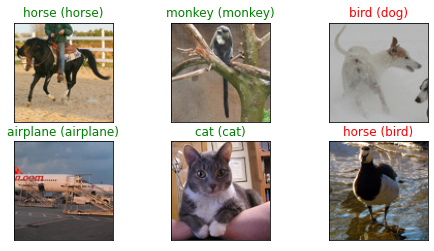

In [87]:
Test_plot(load_model, test_DL)